This file contains python code to compare with sinica method

It is under the linear setting

Now, I use the same beta from the paper but the PSD as X

In [5]:
import sys
sys.path.append("../../mypkg")

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from easydict import EasyDict as edict
from tqdm import trange, tqdm
from pprint import pprint
import itertools
from scipy.stats import chi2


In [7]:
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from hdf_utils.data_gen import gen_simu_psd_dataset
from hdf_utils.SIS import SIS_GLIM
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse, cholesky_inv
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl
from splines import obt_bsp_obasis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.opt import HDFOpt
from scenarios.simu_linear_psd import settings

from joblib import Parallel, delayed

In [9]:
plt.style.use(FIG_ROOT/"base.mplstyle")
torch.set_default_tensor_type(torch.DoubleTensor)

# Params

In [10]:
np.random.seed(0)
c = 0.0

setting = settings.cmpn1b
data_gen_params = setting.data_gen_params
data_gen_params.cs = data_gen_params.cs_fn(c)
data_gen_params.gt_beta = data_gen_params.beta_fn(data_gen_params.cs)

num_rep = 200
Cmat = np.eye(data_gen_params.d - len(setting.sel_idx))
save_dir = RES_ROOT/f"simu_setting{setting.setting}_test"
if not save_dir.exists():
    save_dir.mkdir()

# Simu

## Check data gen fn

In [14]:
data = gen_simu_psd_dataset(n=data_gen_params.n, 
                            d=data_gen_params.d, 
                            q=data_gen_params.q, 
                            types_=data_gen_params.types_, 
                            gt_alp=data_gen_params.gt_alp, 
                            gt_beta=data_gen_params.gt_beta, 
                            freqs=data_gen_params.freqs, 
                            data_type=data_gen_params.data_type, 
                            data_params=data_gen_params.data_params, 
                            seed=0, 
                            is_std=data_gen_params.is_std, 
                            verbose=1, 
                            is_gen=False);

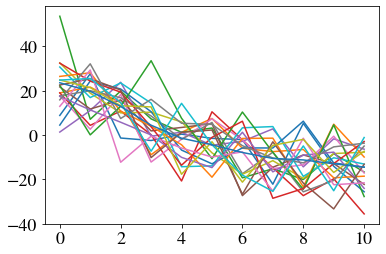

In [15]:
sub_idx = 10
for roi_ix in range(20):
    plt.plot(data.X[sub_idx, roi_ix, :])
plt.plot(data.X[sub_idx, :, :].mean(axis=0))

## SIS check (just for check)

In [12]:
def _SIS_fn(seed, SIS_ratio, N, SIS_pen, setting):
    torch.set_default_dtype(torch.double)
    np.random.seed(seed)
    torch.manual_seed(seed)
        
    data_gen_params = edict(setting.data_gen_params.copy())
    basis_mat = torch.tensor(obt_bsp(np.linspace(0, 1, data_gen_params.npts), N, 4)).to(torch.get_default_dtype())
    cur_data = gen_simu_psd_dataset(n=data_gen_params.n, 
                                    d=data_gen_params.d, 
                                    q=data_gen_params.q, 
                                    types_=data_gen_params.types_, 
                                    gt_alp=data_gen_params.gt_alp, 
                                    gt_beta=data_gen_params.gt_beta, 
                                    freqs=data_gen_params.freqs, 
                                    data_type=data_gen_params.data_type, 
                                    data_params=data_gen_params.data_params, 
                                    seed=seed, 
                                    is_std=data_gen_params.is_std, 
                                    verbose=1, 
                                    is_gen=False);
    
    keep_idxs, _  = SIS_GLIM(Y=cur_data.Y, X=cur_data.X, Z=cur_data.Z, 
                             basis_mat=basis_mat, keep_ratio=SIS_ratio, 
                             model_type=setting.model_type, SIS_pen=SIS_pen, sel_idx=setting.sel_idx)
    M_idxs = np.delete(np.arange(data_gen_params.d), setting.sel_idx)
    keep_idxs = np.sort(np.concatenate([M_idxs, keep_idxs]))
    return keep_idxs

In [13]:
obt_bsp = obt_bsp_obasis_Rfn
num_rep = 200
with Parallel(n_jobs=20) as parallel:
    keep_idxss = parallel(delayed(_SIS_fn)(seed, 0.10, N=8, SIS_pen=0.02, setting=setting) for seed in 
                          tqdm(range(0, num_rep), total=num_rep))

 10%|███████▌                                                                   | 20/200 [00:00<00:02, 71.75it/s]R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate


R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The follo

Text(0.5, 1.0, '[0.15  0.07  0.105 0.08  0.135 0.115 0.085 0.075 1.   ]')

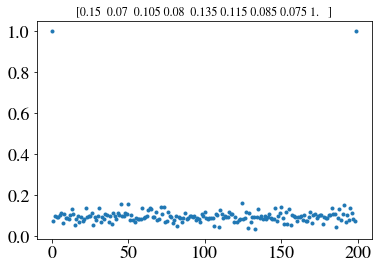

In [14]:
vs, cts = np.unique(np.concatenate(keep_idxss), return_counts=1);
cts = cts[np.argsort(vs)]/len(keep_idxss)
vs = np.sort(vs);
plt.plot(vs, cts, ".")
plt.title(f"{cts[vs > 190]}")

## Simulation

In [15]:
def _run_fn(seed, lam, N, setting, is_save=False, is_cv=False, verbose=2):
    """Now (on Aug 25, 2023), if we keep seed the same, the cur_data is the same. 
       If you want to make any changes, make sure this. 
    """
    torch.set_default_dtype(torch.double)
    np.random.seed(seed)
    torch.manual_seed(seed)
        
    _setting = edict(setting.copy())
    _setting.seed = seed
    _setting.lam = lam
    _setting.N = N
    
    data_gen_params = setting.data_gen_params
    
    f_name = f"seed_{seed:.0f}-lam_{lam*1000:.0f}-N_{N:.0f}_fit.pkl"
    
    
    if not (save_dir/f_name).exists():
        cur_data = gen_simu_psd_dataset(n=data_gen_params.n, 
                            d=data_gen_params.d, 
                            q=data_gen_params.q, 
                            types_=data_gen_params.types_, 
                            gt_alp=data_gen_params.gt_alp, 
                            gt_beta=data_gen_params.gt_beta, 
                            freqs=data_gen_params.freqs, 
                            data_type=data_gen_params.data_type, 
                            data_params=data_gen_params.data_params, 
                            seed=seed, 
                            is_std=data_gen_params.is_std, 
                            verbose=verbose, 
                            is_gen=False);
        hdf_fit = HDFOpt(lam=_setting.lam, 
                         sel_idx=_setting.sel_idx, 
                         model_type=_setting.model_type,
                         verbose=verbose, 
                         SIS_ratio=_setting.SIS_ratio, 
                         N=_setting.N,
                         is_std_data=True, 
                         cov_types=None, 
                         inits=None,
                         model_params = _setting.model_params, 
                         SIS_params = _setting.SIS_params, 
                         opt_params = _setting.opt_params,
                         bsp_params = _setting.bsp_params, 
                         pen_params = _setting.pen_params
               );
        hdf_fit.add_data(cur_data.X, cur_data.Y, cur_data.Z)
        opt_res = hdf_fit.fit()
        
        if is_cv:
            hdf_fit.get_cv_est(_setting.num_cv_fold)
        if is_save:
            hdf_fit.save(save_dir/f_name, is_compact=False, is_force=True)
    else:
        hdf_fit = load_pkl(save_dir/f_name, verbose>=2);
        
    return hdf_fit


### single test

In [16]:
seed = 1
lam = 2.0
N = 6

res = _run_fn(seed=seed, lam=lam, N=N, setting=setting, is_cv=True, is_save=False, verbose=2)
#res._prepare_hypotest()
#res.hypo_test(Cmat)

2024-02-15 14:33:22,918 - optimization.opt - INFO - opt parmas is {'stop_cv': 0.0005, 'max_iter': 2000, 'one_step_verbose': 0, 'alpha': 0.9, 'beta': 10, 'R': 200000.0, 'linear_theta_update': 'cholesky_inv'}.
2024-02-15 14:33:22,919 - optimization.opt - INFO - SIS parmas is {'SIS_pen': 0.02, 'SIS_basis_N': 8, 'SIS_basis_ord': 4, 'SIS_ratio': 0.2}.
2024-02-15 14:33:22,920 - optimization.opt - INFO - model parmas is {'norminal_sigma2': 1}.
2024-02-15 14:33:22,920 - optimization.opt - INFO - penalty parmas is {'a': 3.7, 'lam': 2.0}.
2024-02-15 14:33:22,921 - optimization.opt - INFO - bspline parmas is {'basis_ord': 4, 'is_orth_basis': True, 'N': 6}.
2024-02-15 14:33:22,921 - optimization.opt - INFO - As cov_types is not provided, inferring the continuous covariates.
R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate




Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_cmp2sinica/../../mypkg/../mid_results/PSD_d-200_n-100_npts-100_is_std-False/seed_1.pkl


Cross Validation: 100%|██████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.49it/s]


In [17]:
Cmat = np.eye(1)
#########ts = setting.data_gen_params.gt_beta[:, :1];
res.hypo_test(Cmat, ts=None)

2024-02-15 14:33:26,113 - optimization.opt - INFO - hypo parmas is {'svdinv_eps_Q': 1e-07, 'svdinv_eps_Psi': 1e-07, 'Cmat': array([[1.]])}.


{'pval': 0.23354556068152926, 'T_v': tensor(8.0627)}

### Multipe test

In [18]:
def outlier_det(T_vs, ratio_tol=0.05):
    """
    Detects outliers in a given dataset using the interquartile range (IQR) method.

    Parameters:
    - T_vs (array-like): The input dataset.
    - ratio_tol (float, optional): The tolerance ratio for outlier removal. Default is 0.05.

    Returns:
    - kpidx (ndarray): A boolean array indicating whether each data point is an outlier or not.
    """
    Q1, Q3 = np.quantile(T_vs, [0.25, 0.75])
    IQR = Q3 - Q1
    upbd = Q3 + 1.5*IQR
    lowbd = Q1 - 1.5*IQR
    kpidx = np.bitwise_and(T_vs>=lowbd, T_vs<=upbd)
    
    if np.mean(kpidx)+ ratio_tol < 1:
        out_part = np.stack([T_vs - upbd, lowbd - T_vs]).T.max(axis=1);
        kpidx = np.ones(len(T_vs), dtype=bool)
        kpidx[np.argsort(-out_part)[:int(len(T_vs)*ratio_tol)]] = False
    return kpidx

In [19]:
Cmat = np.eye(1)
ts = None

In [24]:
N = 6
lam = 1.0
#setting.opt_params.beta = 10
def _run_fn1(seed):
    res = _run_fn(seed=seed, lam=lam, N=N, setting=setting, is_cv=False, verbose=1)
    res.hypo_test(Cmat, ts=ts, is_simpler=False)
    test_res = edict()
    test_res.update(res.hypo_test_res)
    test_res.L0 = torch.sum(torch.linalg.norm(res.est_Gam, axis=0)!=0).item()
    test_res.iters = res.conv_iter
    return test_res
    
num_rep = 200
with Parallel(n_jobs=20) as parallel:
    test_ress = parallel(delayed(_run_fn1)(seed) for seed in tqdm(range(num_rep), total=num_rep))
    

100%|██████████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 38.62it/s]


The size is 0.050 and the mean of Tv is 5.899 and thoeretically it is 6. L0 is 7.26.


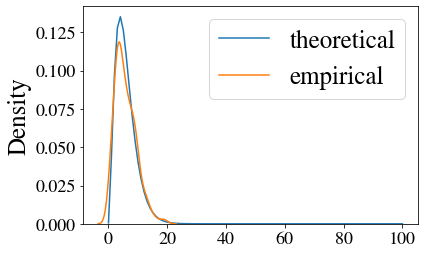

In [25]:
pvals = np.array([res.pval for res in test_ress])
T_vs = np.array([res.T_v for res in test_ress]);
L0s = np.array([res.L0 for res in test_ress]);
chi_df = Cmat.shape[0]*N
kpidx = outlier_det(T_vs, 0.00)
print(
    f"The size is {np.mean(pvals[kpidx]<0.05):.3f} and "
    f"the mean of Tv is {np.mean(T_vs[kpidx]):.3f} and thoeretically it is {chi_df:.0f}. "
    f"L0 is {np.mean(L0s[kpidx]):.2f}."
     )

chi_df = Cmat.shape[0]*N
xs = np.linspace(0.1, 100, 100)
theo_curvs_log = chi2.logpdf(xs, chi_df);
plt.plot(xs, np.exp(theo_curvs_log) , label="theoretical")
sns.kdeplot(T_vs[kpidx], label="empirical")
plt.legend()

### Chcek

In [11]:
from hdf_utils.likelihood import obt_lin_tm

In [8]:
class HDFOpt1(HDFOpt):
     
    def get_cv_est(self, num_cv_fold=5):
        """
        Get CV estimate for each Y
        """
        assert self.X is not None, f"Plz add data by .add_data() first."
        n = self.data_params.n
        
        num_test = int(n/num_cv_fold)
        full_idx = np.arange(n)
        test_Y_est_all = []
        if self.verbose >= 2:
            prg_bar = trange(num_cv_fold, desc="Cross Validation")
        else:
            prg_bar = range(num_cv_fold)
            
        for ix in prg_bar:
            test_idx = full_idx[(ix*num_test):(ix*num_test+num_test)]
            if ix == num_cv_fold-1:
                test_idx = full_idx[(ix*num_test):] # including all remaining data
            train_idx = np.delete(full_idx, test_idx)
            
            test_set_X = self.X[test_idx]
            test_set_Y = self.Y[test_idx]
            test_set_Z = self.Z[test_idx]
            
            train_set_X = self.X[train_idx]
            train_set_Y = self.Y[train_idx]
            train_set_Z = self.Z[train_idx]
            
            if self.is_std_data:
                con_idxs = self.con_idxs
                test_set_X = test_set_X - train_set_X.mean(axis=0, keepdims=True)
                test_set_Z[:, con_idxs] = (test_set_Z[:, con_idxs] - train_set_Z[:, con_idxs].mean(axis=0, keepdims=True))/train_set_Z[:, con_idxs].std(axis=0, keepdims=True)
                
                train_set_X = train_set_X - train_set_X.mean(axis=0, keepdims=True)
                train_set_Z[:, con_idxs] = (train_set_Z[:, con_idxs] - train_set_Z[:, con_idxs].mean(axis=0, keepdims=True))/train_set_Z[:, con_idxs].std(axis=0, keepdims=True)
                
                
                if self.model_type.startswith("linear"):
                    test_set_Y = test_set_Y - train_set_Y.mean(axis=0, keepdims=True)
                    train_set_Y = train_set_Y - train_set_Y.mean(axis=0, keepdims=True)
            self.opt_params["linear_mat"] = None
            cv_res, cur_keep_idxs = self._fit(self.pen_params.lam, self.bsp_params.N, train_set_X, train_set_Y, train_set_Z, 
                                              is_pbar=False, is_cv=True)
            est_alp = cv_res.alpk
            est_Gam = cv_res.Gamk
            test_Y_est = obt_lin_tm(test_set_Z, test_set_X[:, cur_keep_idxs], est_alp, est_Gam, self.basis_mat)
            if self.model_type.startswith("linear"):
                test_Y_est_all.append(test_Y_est.numpy())
            elif self.model_type.startswith("logi"):
                test_Y_est_all.append(logit_fn(test_Y_est.numpy()))
                
        self.cv_Y_est = np.concatenate(test_Y_est_all)
        self.cv_res = cv_res
        return self.cv_Y_est

In [12]:
seed = 0 
torch.set_default_dtype(torch.double)
np.random.seed(seed)
torch.manual_seed(seed)
    
_setting = edict(setting.copy())
_setting.seed = 0
_setting.lam = 0.9
_setting.N = 12
verbose =2

data_gen_params = setting.data_gen_params
    
    
cur_data = gen_simu_psd_dataset(n=data_gen_params.n, 
                    d=data_gen_params.d, 
                    q=data_gen_params.q, 
                    types_=data_gen_params.types_, 
                    gt_alp=data_gen_params.gt_alp, 
                    gt_beta=data_gen_params.gt_beta, 
                    freqs=data_gen_params.freqs, 
                    data_type=data_gen_params.data_type, 
                    data_params=data_gen_params.data_params, 
                    seed=seed, 
                    is_std=data_gen_params.is_std, 
                    verbose=verbose, 
                    is_gen=False);
hdf_fit = HDFOpt(lam=_setting.lam, 
                 sel_idx=_setting.sel_idx, 
                 model_type=_setting.model_type,
                 verbose=verbose, 
                 SIS_ratio=_setting.SIS_ratio, 
                 N=_setting.N,
                 is_std_data=True, 
                 cov_types=None, 
                 inits=None,
                 model_params = _setting.model_params, 
                 SIS_params = _setting.SIS_params, 
                 opt_params = _setting.opt_params,
                 bsp_params = _setting.bsp_params, 
                 pen_params = _setting.pen_params
       );
hdf_fit.add_data(cur_data.X, cur_data.Y, cur_data.Z)
opt_res = hdf_fit.fit()

hdf_fit.get_cv_est(_setting.num_cv_fold);

2024-01-05 18:47:00,935 - optimization.opt - INFO - opt parmas is {'stop_cv': 0.0005, 'max_iter': 2000, 'one_step_verbose': 0, 'alpha': 0.9, 'beta': 10, 'R': 200000.0, 'linear_theta_update': 'cholesky_inv'}.
2024-01-05 18:47:00,936 - optimization.opt - INFO - SIS parmas is {'SIS_pen': 0.02, 'SIS_basis_N': 8, 'SIS_basis_ord': 4, 'SIS_ratio': 0.2}.
2024-01-05 18:47:00,936 - optimization.opt - INFO - model parmas is {'norminal_sigma2': 1}.
2024-01-05 18:47:00,937 - optimization.opt - INFO - penalty parmas is {'a': 3.7, 'lam': 0.9}.
2024-01-05 18:47:00,937 - optimization.opt - INFO - bspline parmas is {'basis_ord': 4, 'is_orth_basis': True, 'N': 12}.
2024-01-05 18:47:00,938 - optimization.opt - INFO - As cov_types is not provided, inferring the continuous covariates.
R[write to console]: 
Attaching package: ‘orthogonalsplinebasis’


R[write to console]: The following object is masked from ‘package:stats’:

    integrate




Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/simu_real/../../mypkg/../mid_results/PSD_d-68_n-500_npts-100_is_std-False/seed_0.pkl


Cross Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.72it/s]


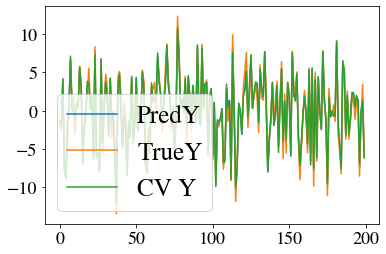

In [13]:
Ypred = obt_lin_tm(hdf_fit.Z, hdf_fit.X[:, hdf_fit.keep_idxs], hdf_fit.est_alp, hdf_fit.est_Gam, hdf_fit.basis_mat);
plt.plot(Ypred.numpy(), label="PredY")
plt.plot(hdf_fit.Y.numpy(), label="TrueY")
plt.plot(hdf_fit.cv_Y_est, label="CV Y")
plt.legend()